In [9]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy
import sys


from src import SingleAgent as sa
from src import helperfunctions as hf

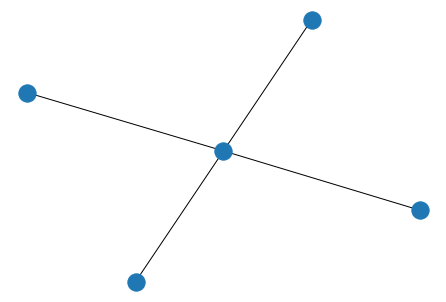

In [10]:
G = nx.star_graph(4)
h = np.zeros(len(G.nodes.keys()))


nx.draw(G)

In [11]:
        
                
budget=1.0
h = np.zeros(len(G.nodes.keys()))

system = sa.mf_ising_system(G,h,iim_iter=1000,fixed_point_iter=int(5*1e4))
beta_crit=hf.crit_b(system.adj_matrix)


In [12]:
exp_beta_list = np.logspace(-0.7, 0.5, endpoint=True,num=200)
iters=10
runs =np.zeros((iters,len(exp_beta_list),system.graph_size))

for run in range(runs.shape[0]):
    control_history=[]
    for i,beta in enumerate(exp_beta_list):
        system = sa.mf_ising_system(G,h,iim_iter=1000,fp_tol_fac=10-4)
        control,_=system.MF_IIM(budget,beta)
        control_history.append(control)
        if i%100==0:
            print(i,beta)
        runs[run,i,:]=control

        
mean_run = np.mean(runs,axis=0)
var_run = np.var(runs,axis=0)
print('FINISHED')    

0 0.19952623149688797
100 0.7998620196059847
0 0.19952623149688797
100 0.7998620196059847
0 0.19952623149688797
100 0.7998620196059847
0 0.19952623149688797
100 0.7998620196059847
0 0.19952623149688797
100 0.7998620196059847
0 0.19952623149688797
100 0.7998620196059847
0 0.19952623149688797
100 0.7998620196059847
0 0.19952623149688797
100 0.7998620196059847
0 0.19952623149688797
100 0.7998620196059847
0 0.19952623149688797
100 0.7998620196059847
FINISHED


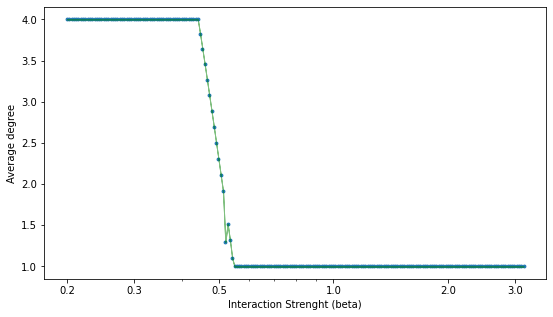

In [13]:


import matplotlib


avs_deg=np.zeros(len(mean_run))
var_deg = np.zeros(len(mean_run))
for it,control in enumerate(mean_run):
    average_degree = np.sum([G.degree[i]*con for i,con in enumerate(control)])
    variance_degree = np.sum([G.degree[i]**2*var for i,var in enumerate(var_run[it])])
    avs_deg[it]=average_degree
    var_deg[it]=variance_degree

fig,ax = plt.subplots(figsize=(9,5))

ax.scatter(exp_beta_list,avs_deg,s=8)
ax.set_xscale(value='log')
ax.fill_between(exp_beta_list, avs_deg-np.sqrt(var_deg), avs_deg+np.sqrt(var_deg),
                    **{'color':'green','alpha':0.5})


ax.set_xticks([0.2,0.3,0.5,1.0,2.0, 3.0])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.set_xlabel(r'Interaction Strenght (beta)')
plt.show()


In [14]:
import torch
per_spin = (budget)/system.graph_size
H = per_spin*torch.ones(system.graph_size,dtype=torch.float64)
H.requires_grad=True


realsystem = sa.TrueSolution(G)

In [7]:
#beta=0.9
# GRADIENT DESCENT WITH ADAM
def theoretical_mag(beta,lr,eps=1e-8):
    epochs =5000
    per_spin = (budget)/system.graph_size
    H = per_spin*torch.ones(system.graph_size,dtype=torch.float64)
    H.requires_grad=True

    
    h_history=np.zeros((epochs,system.graph_size))
    g_history = np.zeros((epochs,system.graph_size))
    
    v = torch.zeros(epochs)
    
    beta1 = 0.9
    beta2 = 0.999
    m = torch.zeros(system.graph_size)
    v = torch.zeros(system.graph_size)

    for i in range(epochs):
        output = -realsystem.magnetisation(H,beta) # note the sign, so that it correspond to maximisation
        output.backward(torch.ones_like(H))
        
        # ADAM OPTIMISER
        m = beta1 * m + (1.0 - beta1) * H.grad.data
        v= beta2 * v + (1.0 - beta2) * H.grad.data**2
        mhat = m / (1.0 - beta1**(i+1))
        vhat = v/ (1.0 - beta2**(i+1))
        
                
        H.data.add_(lr * mhat / (torch.sqrt(vhat) + eps))
        H.data = hf.projection_simplex_sort_torch(H, z=budget)
        H.grad.detach_()
        H.grad.zero_()
        h_grad = H.grad.data.detach().numpy()
        g_history[i]=h_grad
        h_arr = H.detach().numpy()
        h_history[i]=h_arr
        assert np.round(np.sum(h_arr),3)==budget
        if np.sum(np.abs(h_arr-h_history[i-1])) <1e-8:
            break
        
        
    return H.detach().numpy(),h_history,i
    
tx,history,i = theoretical_mag(0.9,0.5)


In [8]:

lr = 0.1

beta_list = np.linspace(0.2, 3.0, endpoint=True,num=20)


iters=10
th_runs =np.zeros((iters,len(beta_list),system.graph_size))

for run in range(th_runs.shape[0]):
    for i,beta in enumerate(beta_list):
        tx,_,it = theoretical_mag(beta,lr)
        if i%10==0:
            print(i,tx,'learning rate',lr,'iteration',it)
            #lr = max(lr*0.5,0.01)
        th_runs[run,i,:]=tx
        

        
mean_th_run = np.mean(th_runs,axis=0)
var_th_run = np.var(th_runs,axis=0)
print('FINISHED')    

0 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 516
10 [0.   0.25 0.25 0.25 0.25] learning rate 0.1 iteration 2
0 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 516
10 [0.   0.25 0.25 0.25 0.25] learning rate 0.1 iteration 2
0 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 516
10 [0.   0.25 0.25 0.25 0.25] learning rate 0.1 iteration 2
0 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 516
10 [0.   0.25 0.25 0.25 0.25] learning rate 0.1 iteration 2
0 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 516
10 [0.   0.25 0.25 0.25 0.25] learning rate 0.1 iteration 2
0 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 516
10 [0.   0.25 0.25 0.25 0.25] learning rate 0.1 iteration 2
0 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 516
10 [0.   0.25 0.25 0.25 0.25] learning rate 0.1 iteration 2
0 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 516
10 [0.   0.25 0.25 0.25 0.25] learning rate 0.1 iteration 2
0 [1. 0. 0. 0. 0.] learning rate 0.1 iteration 516
10 [0.   0.25 0.25 0.25 0.25] learning rate 0.1 iteration 2
0

In [ ]:
th_runs

In [ ]:
import matplotlib


avs_deg_theory=np.zeros(len(mean_th_run))
var_deg_theory = np.zeros(len(mean_th_run))
for it,control in enumerate(mean_th_run):
    average_degree = np.sum([G.degree[i]*con for i,con in enumerate(control)])
    variance_degree = np.sum([G.degree[i]**2*var for i,var in enumerate(var_th_run[it])])
    avs_deg_theory[it]=average_degree
    var_deg_theory[it]=variance_degree

    
matplotlib.rcParams.update({'font.size': 14,'figure.figsize':(10,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})


    
fig,ax = plt.subplots()

ax.plot(beta_list,avs_deg_theory,label='True Optimal',linestyle='dashed',linewidth=3)
ax.fill_between(beta_list, avs_deg_theory-np.sqrt(var_deg_theory), avs_deg_theory+np.sqrt(var_deg_theory),
                    **{'color':'green','alpha':0.5})




ax.plot(exp_beta_list,avs_deg,label='MF-IIM solution',linestyle='dashed',linewidth=3)
ax.fill_between(exp_beta_list, avs_deg-np.sqrt(var_deg), avs_deg+np.sqrt(var_deg),
                    **{'color':'green','alpha':0.5})


ax.vlines(beta_crit,ymin=1,ymax=4,linestyles='dashed',color='black',label=r'$\beta_{crit}$')

ax.legend()
ax.set_xscale(value='log')
ax.set_title('Optimal MF-IIM compared to the True Optimal solution')

ax.set_xticks([0.2,0.3,0.5,1.0,2.0, 3.0])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.set_xlabel(r'Interaction Strenght ($\beta$)')
plt.show()